Thanks for stopping by! Please note, cleaning this notebook is a work in progress! If you have any questions, I encourage you to [reach out](mailto:steven.c.russo@gmail.com).

>Table of Contents
1. Module Imports and Settings
2. Data
3. Features
    1. Variations
    2. Text

---

## Module Imports and Settings

In [1]:
import pandas as pd
import numpy as np

import re
import string
import itertools
from itertools import tee, islice

from seaborn import plt
import seaborn as sns
sns.set(style="whitegrid", palette='Set2')

%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.collocations import *

from textblob import TextBlob

from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [2]:
# Pandas settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 30)
pd.set_option('display.precision', 10)
pd.set_option('display.max_colwidth', 200)

---

## Data
Data come from a [Kaggle Competition](https://www.kaggle.com/c/msk-redefining-cancer-treatment/data) sponsored by [Memorial Sloan Kettering Cancer Center](https://www.mskcc.org). Using the contest's nomenclature, *training data* include expert-defined class identification (i.e., Class 1-9), and *test data* (with no class identification) are used to to for scoring the competition. Therefore, I split the provided *training data* for training and testing my models.

- **Training Variants,** comma separated file containing information about the genetic mutations
   - **ID**, id number of the row used to link the mutation to the clinical evidence''
   - **Gene**, the gene where this genetic mutation is located
   - **Variation**, the amino acid change for this mutation
   - **Class**, the class this genetic mutation has been classified on (1-9; no descriptions are provided for class assignments)  
   
   
- **Training Text**, a double pipe (||) delimited file containing clinical evidence (text) used to classify genetic mutations
   - **ID**, id number of the row used to link the clinical evidence to the genetic mutation
   - **Text**, the clinical evidence (scientific literature) used to classify the genetic mutation

In [3]:
# Training Data (for Kaggle Competition; we use this for our test and train purposes)
dfv = pd.read_csv('../../Data/training_variants')
dft = pd.read_csv("../../Data/training_text",sep="\|\|",
                  engine='python',
                  header=None,
                  skiprows=1,
                  names=["ID","Text"])

In [4]:
# Create dataframe with Features and Text
df = pd.merge(dfv,dft,how = "inner", on = 'ID')

In [5]:
df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kina...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired uniparental disomy (aUPD) is a novel mechanism by which pathogenetic mutations in cancer may be reduced to homozygosity. To help identify novel mutat...
4,4,CBL,L399V,4,"Oncogenic mutations in the monomeric Casitas B-lineage lymphoma (Cbl) gene have been found in many tumors, but their significance remains largely unknown. Several human c-Cbl (CBL) structures have..."


---

# Features

## Variations

In [6]:
# Making mutation variation subtypes!
    # Deltions & Insertions
    # Fusions
    # Deletions
    # Insertions
    # Truncations
    # Frame Shifts
    # Duplications
    # Splicing
    # Methylation
    # Overexpression
    # Point Mutations
    
df['Var_type'] = 'Other'

mask = ((df['Variation'].str.contains('delins')) | (df['Variation'].str.contains('deletion/insertion'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Del Ins'

mask = ((df['Variation'].str.contains('fus')) | (df['Variation'].str.contains('Fus'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Fus'

mask = ((df['Variation'].str.contains('del')) | (df['Variation'].str.contains('Del')) | (df['Variation'].str.contains('DEL'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Del'

mask = ((df['Variation'].str.contains('ins')) | (df['Variation'].str.contains('Ins'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Ins'

mask = ((df['Variation'].str.contains('trunc')) | (df['Variation'].str.contains('Trunc')))  & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Trunc'

mask = (df['Variation'].str.contains('fs')) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'FS'

mask = ((df['Variation'].str.contains('dup')) | (df['Variation'].str.contains('Dup'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Dup'

mask = ((df['Variation'].str.contains('splice')) | (df['Variation'].str.contains('Splice'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Splice'

mask = (df['Variation'].str.contains('methyl')) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Methyl'

mask = ((df['Variation'].str.contains('Overexpression')) | (df['Variation'].str.contains('Amp'))) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Overexpression'
#mask = (df['Variation'].str.contains('Amp')) & (df['Var_type'] == 'Other')
#df.loc[mask, 'Var_type'] = 'Amp'

mask = (df['Variation'].str.contains(r'^\D\d{1,4}[\D\*]')) & (df['Var_type'] == 'Other')
df.loc[mask, 'Var_type'] = 'Point'

In [7]:
df.Var_type.value_counts()
#df[df['Var_type'] != 'Point']

Point             2647
Fus                182
Del                172
Trunc               99
Overexpression      77
Ins                 42
Del Ins             32
Other               22
FS                  20
Dup                 13
Splice              12
Methyl               3
Name: Var_type, dtype: int64

In [8]:
# Get starting nucleotide, position, and ending nucleotide where available.

# These will produce NaN's for many rows, so they might only be useful for predicting amongst
# point mutations. We might need to exclude these columns if the NaN's will mess up a model.

df['gene_from'] = df['Variation'].str.extract(r'(^\D)(\d+)([\D\*])')[0]
df['gene_loc'] = df['Variation'].str.extract(r'(^\D)(\d+)([\D\*])')[1]
df['gene_to'] = df['Variation'].str.extract(r'(^\D)(\d+)([\D\*])')[2]

/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys
/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


# Text

In [9]:
# Look at first characters to check for similarities 
# and figure out how many times an article appears

from itertools import count
c = count()

df['Head'] = df.Text.replace(r'[^0-9a-zA-Za]', '', regex=True).str[:100].str.strip()
df['article_ID'] = df.groupby('Head')['ID'].grouper.group_info[0]
df['article_count'] = df.groupby('Head')['ID'].transform('count')
df.drop('Head', 1, inplace=True)

In [10]:
# Use this to select sentences that mention the Gene or the Variation!!!
# Then put them in the relevant row in a "rel_text" column

for i, row in df.iterrows():
    rel_text = set()
    for sentence in re.split(r'\.\s+(?=[A-Z"\'])', df['Text'][i]):
        if df['Gene'][i].lower() in sentence.lower():
            rel_text.add(sentence + '\n')
        if df['Variation'][i].lower() in sentence.lower():
            rel_text.add(sentence + '\n')
    df.loc[i, 'rel_text'] = ' '.join(rel_text)

# This groups them all together, so when we get ngrams, it will take the last word of one chunk
# and put it with the first word of a new chunk. Adding in the \n to see if we can halt ngrams

In [11]:
# Remove all the stopwords from NLTK's English stopwords list (must import!) that appear in our text.
# Lowercase and stripped of puctuation to determine if stop word.


def remove_stopword(s, stoplist):
    word_list = s.split()
    good_words = [word for word in word_list if 
                  (word.lower().translate(str.maketrans('', '', string.punctuation)) not in stoplist)]
    result = ' '.join(good_words)
    return result

stoplist = set(stopwords.words('english'))
df['rel_text'] = df['rel_text'].apply(lambda x: remove_stopword(x, stoplist))

stoplist2 = set( ["fig", "figure", "et", "al", "table", "data", "analysis", "analyze", "study","method", "result", 
                  "conclusion", "author","find", "found", "show", "perform","demonstrate", "evaluate", "discuss"])
df['rel_text'] = df['rel_text'].apply(lambda x: remove_stopword(x, stoplist2))




In [12]:
# Reset dataframe without blank rel_text rows
df = df[df['rel_text'] != '']

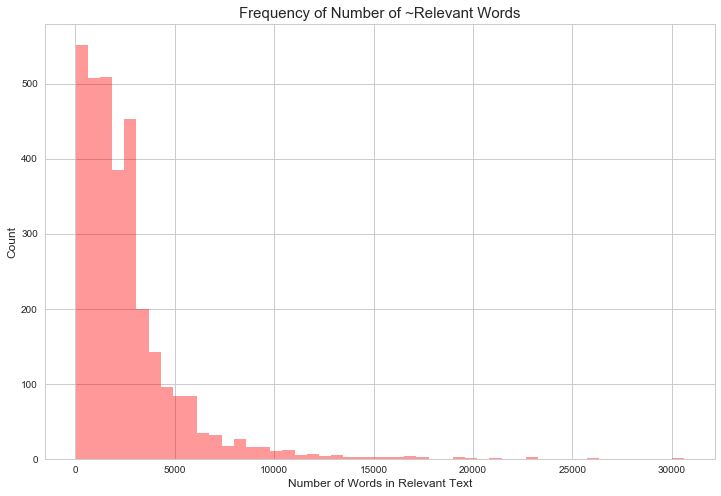

In [13]:
df['rel_Text_num_words'] = df["rel_text"].apply(lambda x: len(str(x).split()) )

plt.figure(figsize=(12, 8))
sns.distplot(df.rel_Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of Words in Relevant Text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of Number of ~Relevant Words", fontsize=15)
plt.show()

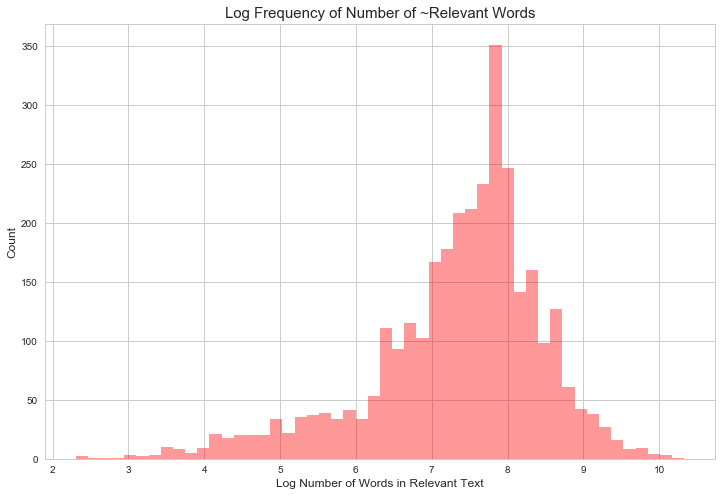

In [14]:
df['log_rel_Text_num_words'] = df["rel_Text_num_words"].apply(lambda x: np.log(x) )

plt.figure(figsize=(12, 8))
sns.distplot(df.log_rel_Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Log Number of Words in Relevant Text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Log Frequency of Number of ~Relevant Words", fontsize=15)
plt.show()

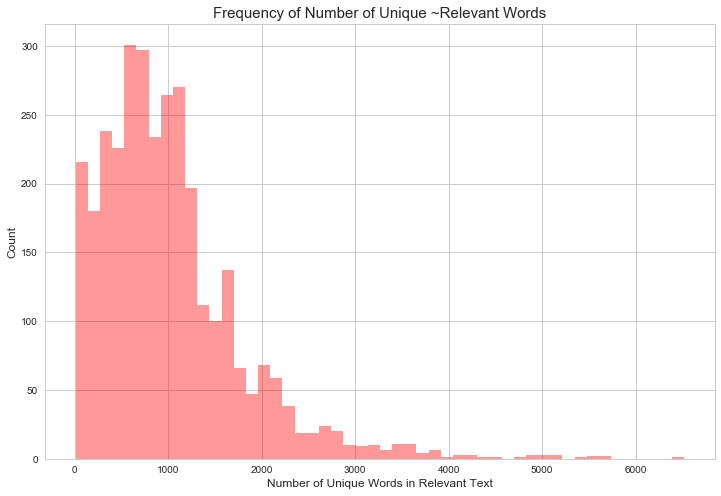

In [15]:
#number of words and number of unique words both have similar distributions
df['rel_Text_num_unique_words'] = df["rel_text"].apply(lambda x: len(set(str(x).split()) ))

plt.figure(figsize=(12, 8))
sns.distplot(df.rel_Text_num_unique_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of Unique Words in Relevant Text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of Number of Unique ~Relevant Words", fontsize=15)
plt.show()

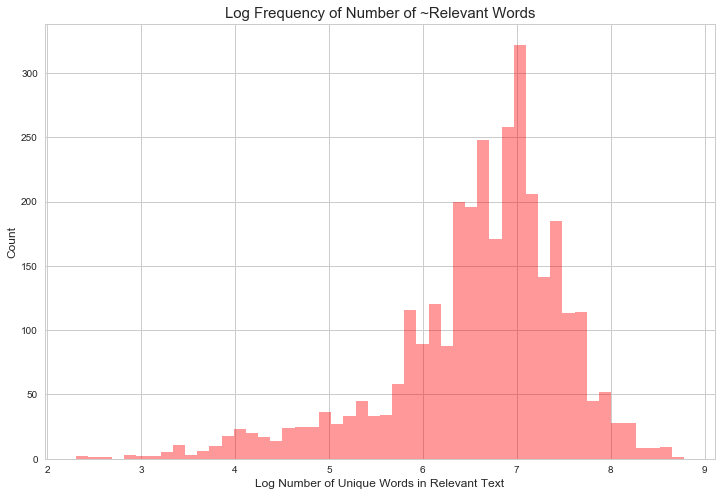

In [16]:
df['log_rel_Text_num_unique_words'] = df["rel_Text_num_unique_words"].apply(lambda x: np.log(x) )

plt.figure(figsize=(12, 8))
sns.distplot(df.log_rel_Text_num_unique_words.values, bins=50, kde=False, color='red')
plt.xlabel('Log Number of Unique Words in Relevant Text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Log Frequency of Number of ~Relevant Words", fontsize=15)
plt.show()

In [17]:
# df # is the Canonical dataframe!

# TF-IDF Model

In [18]:
y_tfidf = df[['ID','Class']]
X_tfidf = df[['ID','rel_text']]
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.25, random_state=4444)



In [19]:
%%time


minNgramLength = 1
maxNgramLength = 5

# custom ngram analyzer function, matching only ngrams that belong to the same line
# https://stackoverflow.com/questions/26907309/create-ngrams-only-for-words-on-the-same-line-disregarding-line-breaks-with-sc
def ngrams_per_line(doc):
    for ln in doc.split('\n'): # analyze each line of the input string seperately
        all_terms = re.findall(u'(?u)\\b\\w+\\b', ln) # tokenize the input string (customize the regex as desired)
        terms = [x for x in all_terms if not x.isdigit()] # take out words that are all digits
        for ngramLength in range(minNgramLength, maxNgramLength+1): # loop ngram creation for every number between min and max ngram length
            # for ngram in zip(*[terms[i:] for i in range(3)]): <-- solution without a generator (works the same but has higher memory usage)
            for ngram in zip(*[islice(seq, i, len(terms)) for i, seq in enumerate(tee(terms, ngramLength))]): # find and return all ngrams
                ngram = ' '.join(ngram)
                yield ngram

                
# Determine your vectorizer properties
# TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model...
vectorizer = TfidfVectorizer(stop_words = 'english', # Doesn't seem like this works if you use custom analyzer, so can remove stop words manuallys
                             ngram_range=(minNgramLength,maxNgramLength),
                             min_df=.04,
                             max_df=.9, # Need max_df high if we are putting in artificial stop words, 
#                                        # but artificial stop words will only work if they cause the ngram
#                                        # to be thrown out, not if they are thrown out befor ngramming.
#                                        # Custom analyzer, along with \n, should take care of this.
                             analyzer=ngrams_per_line)


# Fit our estimator to the training data, and apply the transform to our training data. Makes bag of words from vectorizer
X_train_vector = vectorizer.fit_transform(list(X_train_tfidf.iloc[:,1]))

# Assign the Class values of our training set.
classes = np.array(y_train_tfidf.Class)

# Make bag of words from vectorizer

# Apply the transform (fitted on our training set) to our test set.
X_test_vector = vectorizer.transform(X_test_tfidf.iloc[:,1])

CPU times: user 1min 34s, sys: 3.89 s, total: 1min 38s
Wall time: 1min 42s


In [20]:
X_train = X_train_vector.toarray()
y_train_class = classes
X_test = X_test_vector.toarray()
y_test_class = np.array(y_test_tfidf.Class)

In [21]:
#%%time

clf_name = []
all_clf = []

In [22]:
%%time

clf_multiNB = MultinomialNB()
clf_multiNB.fit(X_train, y_train_class)
y_pred = clf_multiNB.predict(X_test)
clf_name.append('Multinomial Naive Bayes')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.563275434243 w/o resampling
# 0.571960297767 w/ 686 sampling



0.563275434243
CPU times: user 98.9 ms, sys: 15.5 ms, total: 114 ms
Wall time: 85.6 ms


In [23]:
%%time

clf_KNN = KNeighborsClassifier(n_neighbors=3)
clf_KNN.fit(X_train, y_train_class)
y_pred = clf_KNN.predict(X_test)
clf_name.append('k-Nearest Neighbors')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.595533498759 w/o resampling
# 0.585607940447 w/ 686 sampling



0.591811414392
CPU times: user 14.6 s, sys: 72 ms, total: 14.6 s
Wall time: 14.6 s


In [24]:
%%time

clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train_class)
y_pred = clf_LR.predict(X_test)
clf_name.append('Logistic Regression')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.612903225806 w/o resampling
# 0.569478908189 w/ 686 sampling

0.612903225806
CPU times: user 1.72 s, sys: 13.3 ms, total: 1.73 s
Wall time: 1.74 s


In [25]:
%%time

clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train_class)
y_pred = clf_GNB.predict(X_test)
clf_name.append('Gaussian Naive Bayes')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.575682382134 w/o resampling
# 0.547146401985 w/ 686 sampling

0.5682382134
CPU times: user 607 ms, sys: 397 ms, total: 1 s
Wall time: 824 ms


In [26]:
%%time


clf_SVC = SVC(kernel='linear', probability=True)
clf_SVC.fit(X_train, y_train_class)
y_pred = clf_SVC.predict(X_test)
clf_name.append('SVC')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.641439205955 w/o resampling
# 0.578163771712 w/ 686 sampling

0.641439205955
CPU times: user 4min 27s, sys: 1.85 s, total: 4min 29s
Wall time: 4min 35s


In [27]:
%%time



clf_DTC = DecisionTreeClassifier()
clf_DTC.fit(X_train, y_train_class)
y_pred = clf_DTC.predict(X_test)
clf_name.append('Decision Tree')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.559553349876 w/o resampling
# 0.548387096774 w/ 686 sampling

0.56699751861
CPU times: user 5.43 s, sys: 79.2 ms, total: 5.51 s
Wall time: 5.68 s


In [28]:
%%time



clf_RFT = RandomForestClassifier(n_estimators=400, n_jobs = -1)
clf_RFT.fit(X_train, y_train_class)
y_pred = clf_RFT.predict(X_test)
clf_name.append('Random Forest')
all_clf.append(y_pred)
print(accuracy_score(y_test_class, y_pred))

# 0.669975186104 w/o resampling, 400 estimators
# 0.599255583127 w/ 686 sampling

0.661290322581
CPU times: user 30.9 s, sys: 198 ms, total: 31.1 s
Wall time: 8.73 s


In [29]:
all_acc = []
for i in range(len(clf_name)):
    print(clf_name[i]+ ' Classification Report:\n')
    print(classification_report(y_test_class,all_clf[i] ))
    print(accuracy_score(y_test_class, all_clf[i]))
    all_acc.append(accuracy_score(y_test_class, all_clf[i]))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

Multinomial Naive Bayes Classification Report:

             precision    recall  f1-score   support

          1       0.56      0.52      0.54       139
          2       1.00      0.06      0.11       105
          3       0.00      0.00      0.00        19
          4       0.61      0.66      0.63       161
          5       0.41      0.23      0.29        61
          6       0.64      0.39      0.49        69
          7       0.54      0.96      0.69       238
          8       0.00      0.00      0.00         3
          9       0.00      0.00      0.00        11

avg / total       0.60      0.56      0.50       806

0.563275434243
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


k-Nearest Neighbors Classification Report:

             precision    recall  f1-score   support

          1       0.46      0.60      0.52       139
          2       0.47      0.38      0.42       105
          3       0.40      0.63      0.49        19
          4       0.63      0.61      

/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
SVC_probs = clf_SVC.predict_proba(vectorizer.transform(X_tfidf.iloc[:,1]).toarray())

## Make a new model using the max score that decided each category? What does that get us...? Maybe I do this on a class by class basis with the other model...

In [31]:
SVC_probs[0]

array([ 0.6891777 ,  0.05570121,  0.00773425,  0.11542741,  0.02636004,
        0.0243434 ,  0.06476204,  0.01138044,  0.00511351])

In [32]:
%%time
#X_tfidf['SVC_X'] = 
model_1 = df
model_1['SVC_pred1'] = SVC_probs[:,0]
model_1['SVC_pred2'] = SVC_probs[:,1]
model_1['SVC_pred3'] = SVC_probs[:,2]
model_1['SVC_pred4'] = SVC_probs[:,3]
model_1['SVC_pred5'] = SVC_probs[:,4]
model_1['SVC_pred6'] = SVC_probs[:,5]
model_1['SVC_pred7'] = SVC_probs[:,6]
model_1['SVC_pred8'] = SVC_probs[:,7]
model_1['SVC_pred9'] = SVC_probs[:,8]

CPU times: user 5.78 ms, sys: 690 µs, total: 6.47 ms
Wall time: 6.86 ms


In [33]:
model_1.head()

,ID,Gene,Variation,Class,Text,Var_type,gene_from,gene_loc,gene_to,article_ID,...,log_rel_Text_num_unique_words,SVC_pred1,SVC_pred2,SVC_pred3,SVC_pred4,SVC_pred5,SVC_pred6,SVC_pred7,SVC_pred8,SVC_pred9
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kina...,Trunc,NaN,NaN,NaN,339,...,5.8664680569,0.6891776991,0.0557012084,0.0077342486,0.1154274098,0.0263600391,0.0243434036,0.0647620416,0.0113804403,0.0051135095
1,1,CBL,W802*,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...,Point,W,802,*,44,...,6.8844866520,0.1236726719,0.3509231361,0.0277360387,0.2320201411,0.0281025928,0.0808620977,0.1327028633,0.0137982184,0.0101822401
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...,Point,Q,249,E,44,...,6.8844866520,0.1236726719,0.3509231361,0.0277360387,0.2320201411,0.0281025928,0.0808620977,0.1327028633,0.0137982184,0.0101822401
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired uniparental disomy (aUPD) is a novel mechanism by which pathogenetic mutations in cancer may be reduced to homozygosity. To help identify novel mutat...,Point,N,454,D,870,...,6.9007306640,0.0823319964,0.0436598834,0.0709116495,0.6812990993,0.0393616294,0.0233035527,0.0453565620,0.0081333554,0.0056422719
4,4,CBL,L399V,4,"Oncogenic mutations in the monomeric Casitas B-lineage lymphoma (Cbl) gene have been found in many tumors, but their significance remains largely unknown. Several human c-Cbl (CBL) structures have...",Point,L,399,V,779,...,6.9087547793,0.0743600884,0.0159330253,0.0120998257,0.7371021233,0.0992742048,0.0435909528,0.0095955312,0.0042909551,0.0037532934


In [34]:

models = {'Multinomial Naive Bayes': MultinomialNB(),
          'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
          'Logistic Regression': LogisticRegression(),
          'Gaussian NB': GaussianNB(),
          'SVC': SVC(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier()}

#fig, axes = plt.subplots(4,2, figsize=(18,20))
#fig.subplots_adjust(hspace=.25)

#i, j = 0, 0

def plot_cm(model):
    plt.figure(figsize=(16,8))

    model.fit(X_train, y_train_class)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_class, y_pred)
    
    classes=list(range(1,10))
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    #try:
    #    y_score = model.predict_proba(X_test)[:,1]
    #except AttributeError:
    #    y_score = model.decision_function(X_test)
    #    
    #curve = roc_curve(y_test, y_score)
    #auc = roc_auc_score(y_test, y_score)
    thresh = cm.max() / 2.5

    plt.imshow([cm[i]/np.apply_along_axis(np.sum, 1, cm)[i] for i in range(9)], interpolation='nearest', cmap=plt.cm.Greens)
    #axes[i][j].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize = 16,
                 color="white" if cm[i, j] > thresh else "black").set_alpha(.8 if cm[i,j] > 0 else 0)

    #axes[i][j].set_title(name +' ROC')
    #axes[i][j].set_xlabel('False Positive Rate\n'+'AUC = '+ str(auc))
    #axes[i][j].set_ylabel('True Positive Rate')
    plt.grid(False)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.colorbar()
    
    #if j == 1:
    #    i += 1
    #    j = 0
    #else:
    #    j += 1


In [35]:
##Test for making each color represent portion of actual for that given class
#this_model = MultinomialNB()
#this_model.fit(X_train, y_train_class)
#y_pred = this_model.predict(X_test)
#cm =  confusion_matrix(y_test_class, y_pred)
#cm/np.apply_along_axis(np.sum, 1, cm)

## Numbers represent Predictions vs True. Colors represent portion of class, by row

In [38]:
model = SVC(kernel='linear')
model.fit(X_train, y_train_class)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test_class, y_pred)
cm = confusion_matrix(y_test_class, y_pred)/np.apply_along_axis(np.sum, 1, cm)
cm

array([[ 0.64748201,  0.00952381,  0.        ,  0.16149068,  0.2295082 ,
         0.04347826,  0.0210084 ,  0.        ,  0.        ],
       [ 0.02877698,  0.31428571,  0.        ,  0.02484472,  0.        ,
         0.01449275,  0.26470588,  0.        ,  0.        ],
       [ 0.01438849,  0.        ,  0.        ,  0.01242236,  0.04918033,
         0.        ,  0.05042017,  0.        ,  0.        ],
       [ 0.21582734,  0.01904762,  0.        ,  0.70186335,  0.09836066,
         0.01449275,  0.03361345,  0.        ,  0.09090909],
       [ 0.09352518,  0.        ,  0.        ,  0.04347826,  0.2295082 ,
         0.11594203,  0.07983193,  0.        ,  0.        ],
       [ 0.07194245,  0.01904762,  0.        ,  0.01863354,  0.06557377,
         0.62318841,  0.02941176,  0.        ,  0.        ],
       [ 0.02877698,  0.07619048,  0.        ,  0.03726708,  0.01639344,
         0.        ,  0.92016807,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [40]:
# In our graphing function, I thought we were showing what
# had the greatest chance of being predicted, but mean
# is set once, not each iteration, so I added this temporary
# solve for SVC
temp_thingy = np.apply_along_axis(np.sum, 1, confusion_matrix(y_test_class, y_pred))



In [41]:
temp_thingy

array([139, 105,  19, 161,  61,  69, 238,   3,  11])

In [42]:
[confusion_matrix(y_test_class, y_pred)/temp_thingy[i] for i in range(9)]


[array([[ 0.64748201,  0.00719424,  0.        ,  0.18705036,  0.10071942,
          0.02158273,  0.03597122,  0.        ,  0.        ],
        [ 0.02877698,  0.23741007,  0.        ,  0.02877698,  0.        ,
          0.00719424,  0.45323741,  0.        ,  0.        ],
        [ 0.01438849,  0.        ,  0.        ,  0.01438849,  0.02158273,
          0.        ,  0.08633094,  0.        ,  0.        ],
        [ 0.21582734,  0.01438849,  0.        ,  0.81294964,  0.04316547,
          0.00719424,  0.05755396,  0.        ,  0.00719424],
        [ 0.09352518,  0.        ,  0.        ,  0.05035971,  0.10071942,
          0.05755396,  0.13669065,  0.        ,  0.        ],
        [ 0.07194245,  0.01438849,  0.        ,  0.02158273,  0.02877698,
          0.30935252,  0.05035971,  0.        ,  0.        ],
        [ 0.02877698,  0.05755396,  0.        ,  0.04316547,  0.00719424,
          0.        ,  1.57553957,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , 

In [43]:
cm/temp_thingy

array([[  4.65814399e-03,   9.07029478e-05,   0.00000000e+00,
          1.00304772e-03,   3.76242945e-03,   6.30119723e-04,
          8.82706024e-05,   0.00000000e+00,   0.00000000e+00],
       [  2.07028622e-04,   2.99319728e-03,   0.00000000e+00,
          1.54315034e-04,   0.00000000e+00,   2.10039908e-04,
          1.11220959e-03,   0.00000000e+00,   0.00000000e+00],
       [  1.03514311e-04,   0.00000000e+00,   0.00000000e+00,
          7.71575171e-05,   8.06234883e-04,   0.00000000e+00,
          2.11849446e-04,   0.00000000e+00,   0.00000000e+00],
       [  1.55271466e-03,   1.81405896e-04,   0.00000000e+00,
          4.35939971e-03,   1.61246977e-03,   2.10039908e-04,
          1.41232964e-04,   0.00000000e+00,   8.26446281e-03],
       [  6.72843021e-04,   0.00000000e+00,   0.00000000e+00,
          2.70051310e-04,   3.76242945e-03,   1.68031926e-03,
          3.35428289e-04,   0.00000000e+00,   0.00000000e+00],
       [  5.17571554e-04,   1.81405896e-04,   0.00000000e+00,
   

In [45]:
[cm[i]/temp_thingy[i] for i in range(len(temp_thingy))]

[array([  4.65814399e-03,   6.85166153e-05,   0.00000000e+00,
          1.16180348e-03,   1.65113811e-03,   3.12793244e-04,
          1.51139593e-04,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.00027407,  0.0029932 ,  0.        ,  0.00023662,  0.        ,
         0.00013803,  0.00252101,  0.        ,  0.        ]),
 array([ 0.00075729,  0.        ,  0.        ,  0.00065381,  0.00258844,
         0.        ,  0.00265369,  0.        ,  0.        ]),
 array([  1.34054247e-03,   1.18308193e-04,   0.00000000e+00,
          4.35939971e-03,   6.10935750e-04,   9.00171032e-05,
          2.08779164e-04,   0.00000000e+00,   5.64652739e-04]),
 array([ 0.0015332 ,  0.        ,  0.        ,  0.00071276,  0.00376243,
         0.00190069,  0.00130872,  0.        ,  0.        ]),
 array([ 0.00104264,  0.00027605,  0.        ,  0.00027005,  0.00095034,
         0.00903172,  0.00042626,  0.        ,  0.        ]),
 array([  1.20911674e-04,   3.20128051e-04,   0.00000000e+00,
          1.56584373e-

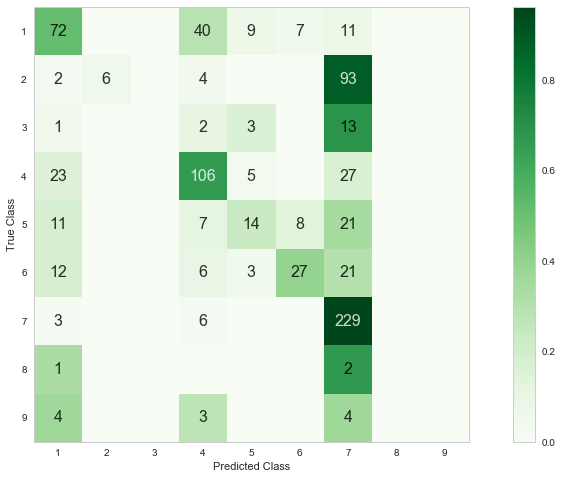

In [46]:
plot_cm(MultinomialNB())

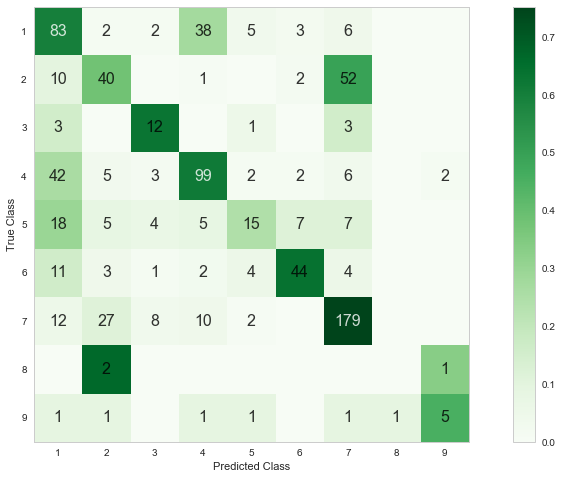

In [47]:
plot_cm(KNeighborsClassifier(n_neighbors=3))

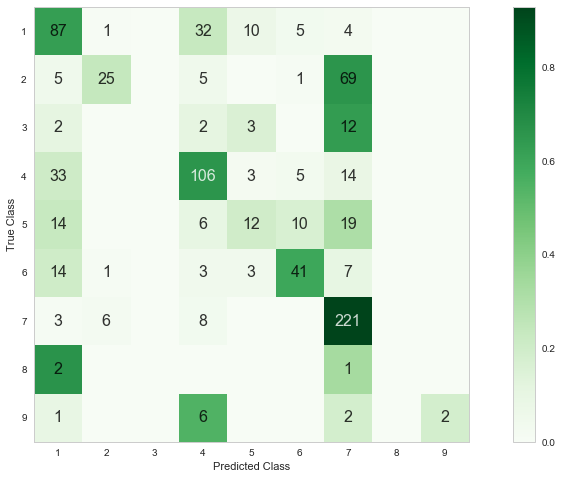

In [48]:
plot_cm(LogisticRegression())

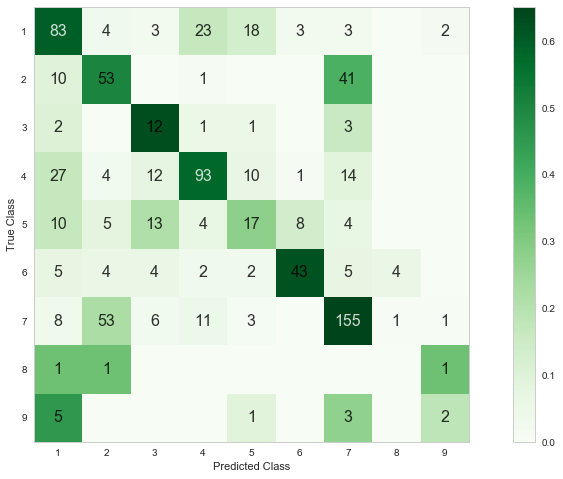

In [49]:
plot_cm(GaussianNB())

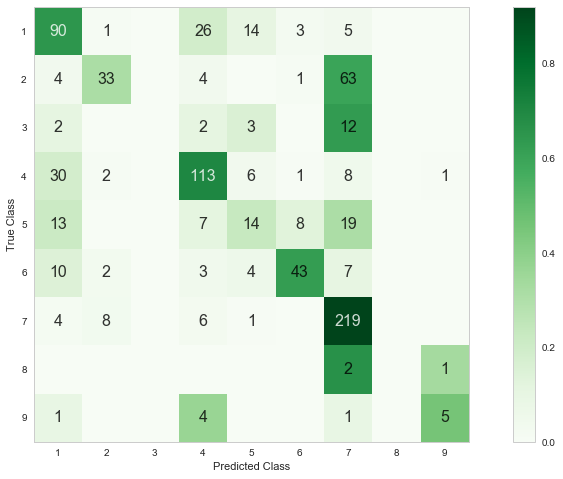

In [50]:
plot_cm(SVC(kernel='linear'))

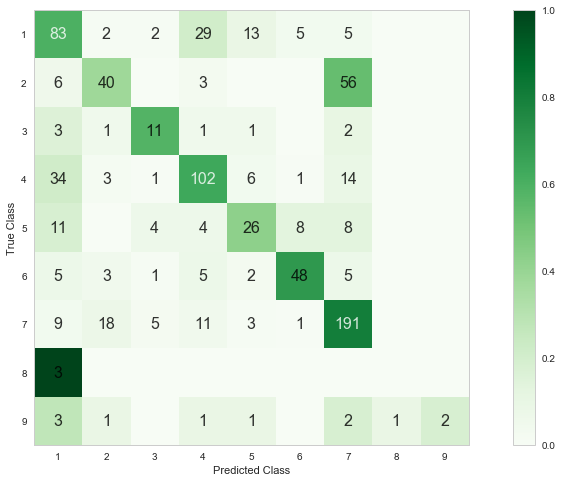

In [51]:
plot_cm(RandomForestClassifier())

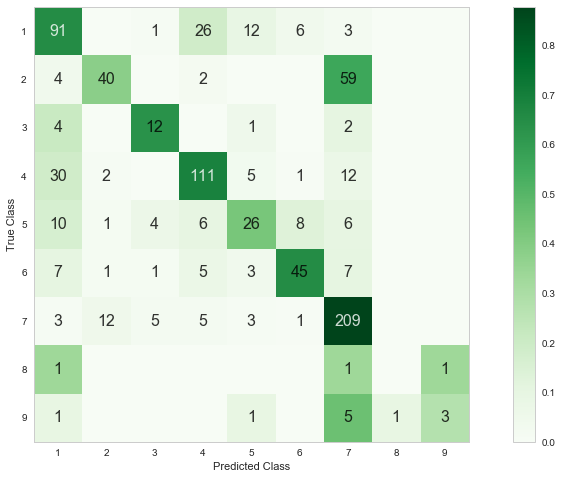

In [52]:
plot_cm(RandomForestClassifier(n_estimators=400, n_jobs = -1))

# Features Model

In [53]:
#df_feature_dropNaN = df[['Class', 'Gene','Var_type','gene_from','gene_loc','gene_to',
#   'article_count','rel_Text_num_words', 'log_rel_Text_num_words',
#   'rel_Text_num_unique_words', 'log_rel_Text_num_unique_words']].dropna(0)

#
df_feature_blankNaN = df[['Class', 'Gene','Var_type','gene_from','gene_loc','gene_to',
   'article_count','rel_Text_num_words', 'log_rel_Text_num_words',
   'rel_Text_num_unique_words', 'log_rel_Text_num_unique_words']].fillna('')

import patsy

#y_fDn, X_fDn = patsy.dmatrices('Class ~ Gene + Var_type + gene_from + gene_loc + gene_to + article_count + rel_Text_num_words + rel_Text_num_unique_words', data=df_feature_dropNaN, return_type = 'dataframe')
#X_fDn.drop(['Intercept'], 1, inplace=True)
#y_fDn = df_feature_dropNaN[['Class']]
#X_fDn = df_feature_dropNaN.drop('Class', 1)
#X_train_fDn, X_test_fDn, y_train_fDn, y_test_fDn = train_test_split(X_fDn, y_fDn, test_size=0.25, random_state=4444)


y_fBn, X_fBn = patsy.dmatrices('Class ~ Gene + Var_type + gene_from + gene_loc + gene_to + article_count + rel_Text_num_words + rel_Text_num_unique_words', data=df_feature_blankNaN, return_type = 'dataframe')
X_fBn.drop(['Intercept'], 1, inplace=True)
#y_fBn = df_feature_blankNaN[['Class']]
#X_fBn = df_feature_blankNaN.drop('Class', 1)
X_train_fBn, X_test_fBn, y_train_fBn, y_test_fBn = train_test_split(X_fBn, y_fBn, test_size=0.25, random_state=4444)




In [54]:
X_fBn

,Gene[T.ACVR1],Gene[T.AGO2],Gene[T.AKT1],Gene[T.AKT2],Gene[T.AKT3],Gene[T.ALK],Gene[T.APC],Gene[T.AR],Gene[T.ARAF],Gene[T.ARID1A],...,gene_to[T.V],gene_to[T.W],gene_to[T.Y],gene_to[T._],gene_to[T.d],gene_to[T.f],gene_to[T.i],article_count,rel_Text_num_words,rel_Text_num_unique_words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,504.0,353.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2108.0,977.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2108.0,977.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1888.0,993.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2278.0,1001.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2278.0,1001.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2272.0,999.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6198.0,2159.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4834.0,1614.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2540.0,794.0


In [55]:
df_feature_blankNaN.dtypes

Class                              int64
Gene                              object
Var_type                          object
gene_from                         object
gene_loc                          object
gene_to                           object
article_count                      int64
rel_Text_num_words                 int64
log_rel_Text_num_words           float64
rel_Text_num_unique_words          int64
log_rel_Text_num_unique_words    float64
dtype: object

In [56]:
%%time

all_feat_clf = []
clf_feat_name = []

clf_feat_RFT = RandomForestClassifier(n_estimators=10000, n_jobs = -1)

clf_feat_DTC = DecisionTreeClassifier()
clf_feat_DTC.fit(X_train_fBn, y_train_fBn)
y_pred = clf_feat_DTC.predict(X_test_fBn)
#clf_feat_name.append('Random Forest - fBn')
#all_clf.append(y_pred)

#clf_feat_RFT.fit(X_train_fDn, y_train_fDn)
#y_pred = clf_feat_RFT.predict(X_test_fDn)
#clf_feat_name.append('Random Forest - fDn')
#all_clf.append(y_pred)
#    
#print(clf_feat_name[0] + ' Classification Report:\n')
#print(classification_report(y_test_fDn, y_pred))
#print(accuracy_score(y_test_fDn, y_pred))
#print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')


clf_feat_RFT.fit(X_train_fBn, y_train_fBn)
y_pred = clf_feat_RFT.predict(X_test_fBn)
clf_feat_name.append('Random Forest - fBn')
all_clf.append(y_pred)
    
print(clf_feat_name[0]+ ' Classification Report:\n')
print(classification_report(y_test_fBn, y_pred ))
print(accuracy_score(y_test_fBn, y_pred))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')




/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest - fBn Classification Report:

             precision    recall  f1-score   support

        1.0       0.65      0.63      0.64       139
        2.0       0.45      0.26      0.33       105
        3.0       0.50      0.16      0.24        19
        4.0       0.68      0.73      0.71       161
        5.0       0.62      0.33      0.43        61
        6.0       0.71      0.61      0.66        69
        7.0       0.60      0.84      0.70       238
        8.0       0.50      0.33      0.40         3
        9.0       0.80      0.36      0.50        11

avg / total       0.62      0.62      0.60       806

0.624069478908
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


CPU times: user 5min 24s, sys: 10.9 s, total: 5min 35s
Wall time: 1min 59s


In [57]:
RF_probs = clf_feat_RFT.predict_proba(X_fBn)

In [58]:
#clf_feat_RFT.feature_importances_

importances = clf_feat_RFT.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_feat_RFT.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_fBn.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 1501 (0.075519)
2. feature 1502 (0.075218)
3. feature 1500 (0.063531)
4. feature 190 (0.021430)
5. feature 30 (0.018232)
6. feature 29 (0.016956)
7. feature 267 (0.015623)
8. feature 265 (0.013232)
9. feature 245 (0.011499)
10. feature 260 (0.011025)
11. feature 282 (0.009220)
12. feature 63 (0.008528)
13. feature 48 (0.008097)
14. feature 1490 (0.006634)
15. feature 126 (0.006471)
16. feature 1475 (0.006202)
17. feature 1491 (0.006187)
18. feature 273 (0.006168)
19. feature 264 (0.006005)
20. feature 5 (0.005860)
21. feature 1496 (0.005802)
22. feature 285 (0.005786)
23. feature 1493 (0.005661)
24. feature 270 (0.005591)
25. feature 277 (0.005465)
26. feature 271 (0.005442)
27. feature 283 (0.005278)
28. feature 1485 (0.005242)
29. feature 28 (0.005224)
30. feature 220 (0.004997)
31. feature 276 (0.004924)
32. feature 174 (0.004924)
33. feature 1481 (0.004666)
34. feature 284 (0.004619)
35. feature 1488 (0.004500)
36. feature 1479 (0.004491)
37. feature 148

In [59]:
X_train_fBn.columns[267]

'Var_type[T.Trunc]'

In [60]:
%%time
#X_tfidf['SVC_X'] = 
model_2 = model_1
model_2['RF_feat1'] = RF_probs[:,0]
model_2['RF_feat2'] = RF_probs[:,1]
model_2['RF_feat3'] = RF_probs[:,2]
model_2['RF_feat4'] = RF_probs[:,3]
model_2['RF_feat5'] = RF_probs[:,4]
model_2['RF_feat6'] = RF_probs[:,5]
model_2['RF_feat7'] = RF_probs[:,6]
model_2['RF_feat8'] = RF_probs[:,7]
model_2['RF_feat9'] = RF_probs[:,8]

CPU times: user 4.27 ms, sys: 546 µs, total: 4.82 ms
Wall time: 4.53 ms


In [61]:
model_2.head()

,ID,Gene,Variation,Class,Text,Var_type,gene_from,gene_loc,gene_to,article_ID,...,SVC_pred9,RF_feat1,RF_feat2,RF_feat3,RF_feat4,RF_feat5,RF_feat6,RF_feat7,RF_feat8,RF_feat9
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kina...,Trunc,NaN,NaN,NaN,339,...,0.0051135095,0.9647,0.0117,0.0000,0.0060,0.0001,0.0046,0.0129,0.0000,0.0000
1,1,CBL,W802*,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...,Point,W,802,*,44,...,0.0101822401,0.0932,0.1191,0.0499,0.5619,0.0564,0.0396,0.0794,0.0001,0.0004
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molec...,Point,Q,249,E,44,...,0.0101822401,0.0207,0.6472,0.0233,0.2111,0.0380,0.0123,0.0473,0.0001,0.0000
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired uniparental disomy (aUPD) is a novel mechanism by which pathogenetic mutations in cancer may be reduced to homozygosity. To help identify novel mutat...,Point,N,454,D,870,...,0.0056422719,0.0183,0.0435,0.6345,0.2205,0.0377,0.0097,0.0341,0.0008,0.0009
4,4,CBL,L399V,4,"Oncogenic mutations in the monomeric Casitas B-lineage lymphoma (Cbl) gene have been found in many tumors, but their significance remains largely unknown. Several human c-Cbl (CBL) structures have...",Point,L,399,V,779,...,0.0037532934,0.0162,0.0215,0.0149,0.7871,0.1081,0.0247,0.0270,0.0003,0.0002


# Hypermodel

In [62]:
hypermodel = pd.concat([model_2[['Class']], model_2.iloc[:,-18:]], 1)
X_hm = hypermodel.iloc[:,1:]
y_hm = hypermodel['Class']

In [63]:
X_train_hm, X_test_hm, y_train_hm, y_test_hm = train_test_split(X_hm, y_hm, test_size=0.25, random_state=4444)



In [64]:
name = []
clf = []

In [65]:
%%time


multiNB = MultinomialNB()
multiNB.fit(X_train_hm, y_train_hm)
y_pred = multiNB.predict(X_test_hm)
name.append('Multinomial Naive Bayes')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.563275434243 w/o resampling
# 0.571960297767 w/ 686 sampling




0.647642679901
CPU times: user 6.54 ms, sys: 2.11 ms, total: 8.64 ms
Wall time: 5.98 ms


In [66]:
%%time

KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train_hm, y_train_hm)
y_pred = KNN.predict(X_test_hm)
name.append('k-Nearest Neighbors')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.595533498759 w/o resampling
# 0.585607940447 w/ 686 sampling




0.629032258065
CPU times: user 92.5 ms, sys: 1.61 ms, total: 94.1 ms
Wall time: 48.5 ms


In [67]:
%%time

LR = LogisticRegression()
LR.fit(X_train_hm, y_train_hm)
y_pred = LR.predict(X_test_hm)
name.append('Logistic Regression')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.612903225806 w/o resampling
# 0.569478908189 w/ 686 sampling

0.638957816377
CPU times: user 113 ms, sys: 2.42 ms, total: 115 ms
Wall time: 73.9 ms


In [68]:
%%time

GNB = GaussianNB()
GNB.fit(X_train_hm, y_train_hm)
y_pred = GNB.predict(X_test_hm)
name.append('Gaussian Naive Bayes')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.575682382134 w/o resampling
# 0.547146401985 w/ 686 sampling

0.615384615385
CPU times: user 6.98 ms, sys: 1.15 ms, total: 8.14 ms
Wall time: 6.05 ms


In [69]:
from sklearn.svm import SVC

SVC_model = SVC(kernel='linear', probability=True)
SVC_model.fit(X_train_hm, y_train_hm)
y_pred = SVC_model.predict(X_test_hm)
name.append('SVC')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.641439205955 w/o resampling
# 0.578163771712 w/ 686 sampling

0.611662531017


In [70]:
%%time

DTC = DecisionTreeClassifier()
DTC.fit(X_train_hm, y_train_hm)
y_pred = DTC.predict(X_test_hm)
name.append('Decision Tree')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.559553349876 w/o resampling
# 0.548387096774 w/ 686 sampling

0.487593052109
CPU times: user 32.8 ms, sys: 1.21 ms, total: 34 ms
Wall time: 17.2 ms


In [71]:
%%time

RFT = RandomForestClassifier(n_estimators=400, n_jobs = -1)
RFT.fit(X_train_hm, y_train_hm)
y_pred = RFT.predict(X_test_hm)
name.append('Random Forest')
clf.append(y_pred)
print(accuracy_score(y_test_hm, y_pred))

# 0.669975186104 w/o resampling, 400 estimators
# 0.599255583127 w/ 686 sampling

0.563275434243
CPU times: user 2.29 s, sys: 136 ms, total: 2.43 s
Wall time: 1.06 s


In [72]:
all_acc = []
for i in range(len(name)):
    print(name[i]+ ' Classification Report:\n')
    print(classification_report(y_test_hm,clf[i] ))
    print(accuracy_score(y_test_hm, clf[i]))
    all_acc.append(accuracy_score(y_test_hm, clf[i]))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n')

Multinomial Naive Bayes Classification Report:

             precision    recall  f1-score   support

          1       0.67      0.64      0.65       139
          2       0.63      0.21      0.31       105
          3       0.00      0.00      0.00        19
          4       0.65      0.80      0.72       161
          5       0.50      0.23      0.31        61
          6       0.76      0.61      0.68        69
          7       0.63      0.92      0.75       238
          8       0.00      0.00      0.00         3
          9       0.86      0.55      0.67        11

avg / total       0.63      0.65      0.61       806

0.647642679901
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


k-Nearest Neighbors Classification Report:

             precision    recall  f1-score   support

          1       0.62      0.65      0.64       139
          2       0.44      0.39      0.41       105
          3       0.44      0.21      0.29        19
          4       0.69      0.76      

/Users/stevenrusso/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# LR gives best results... LR, KNN with k=4, SVC, and RF gave incredible results for different splits

In [73]:
import pydotplus
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import io
import graphviz

decision_tree = DecisionTreeRegressor(max_depth=4)
decision_tree.fit(X_train_fBn,y_train_fBn)
print ("Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test_fBn,decision_tree.predict(X_test_fBn))))



Decision Tree RMSE: 2.19373378354


In [77]:
from sklearn.tree import export_graphviz

dot_data = io.StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train_fBn.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  


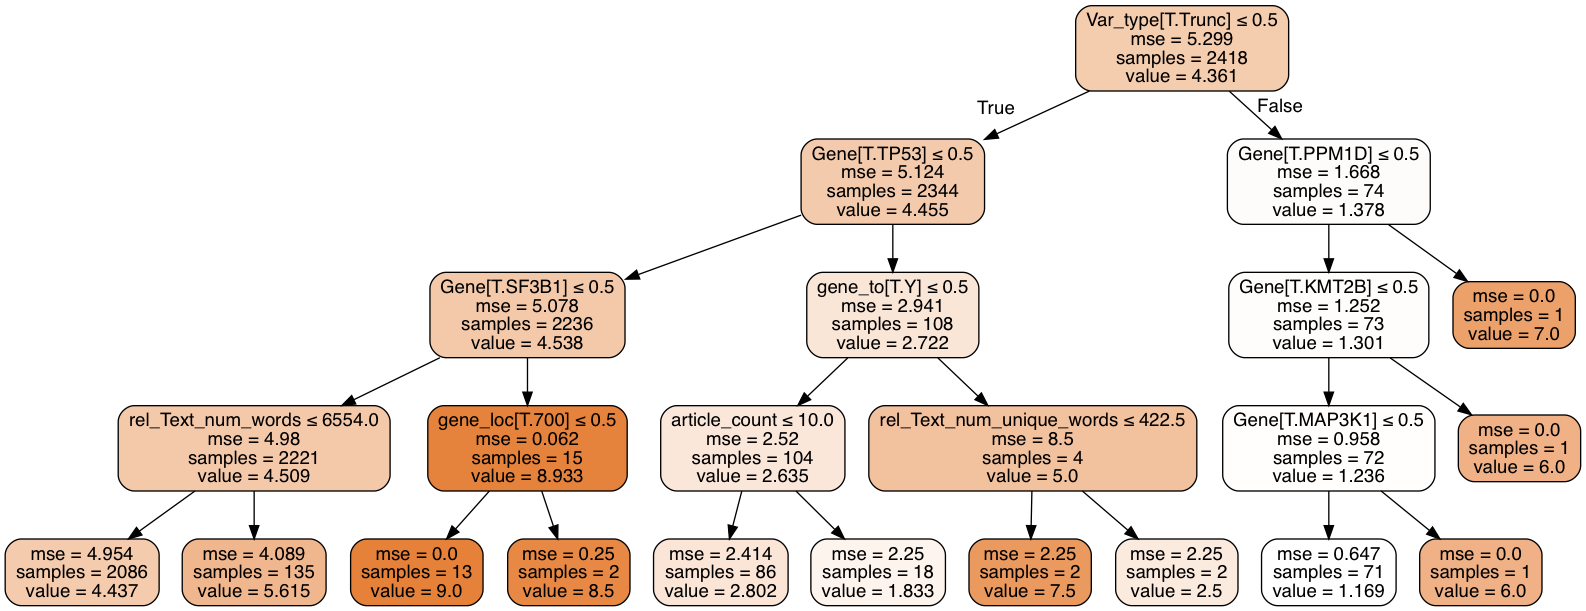

In [79]:
from IPython.display import Image, display

Image(graph.create_png())